# Phase 3: Activation Function Comparison (Sigmoid, Tanh, ReLU, LeakyReLU)

This notebook compares four hidden activation functions while keeping architecture, data preprocessing, optimizer, epochs, and seed fixed. Results include a comparison table and seven plots.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)

from mytorch import Tensor
from mytorch.model import Model
from mytorch.layer import Linear
from mytorch.activation import sigmoid, relu, tanh, leaky_relu
from mytorch.optimizer import SGD

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [15]:
df = pd.read_csv('diabetes.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df_features = pd.DataFrame(X, columns=feature_columns)
for col in zero_not_accepted:
    df_features[col] = df_features[col].replace(0, np.nan)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
print('Preprocessed shape:', X_scaled.shape)

Preprocessed shape: (768, 8)


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)
print(f'Train: {X_train.shape[0]}  Val: {X_val.shape[0]}  Test: {X_test.shape[0]}')

Train: 460  Val: 154  Test: 154


In [17]:
class DiabetesMLP(Model):
    def __init__(self, hidden_activation='relu', input_size=8, h1=64, h2=32, output_size=1):
        super().__init__()
        self.hidden_activation = hidden_activation
        self.fc1 = Linear(input_size, h1, need_bias=False, mode='xavier')
        self.fc2 = Linear(h1, h2, need_bias=False, mode='xavier')
        self.fc3 = Linear(h2, output_size, need_bias=False, mode='xavier')
    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1.forward(x)
        if self.hidden_activation == 'relu':
            x = relu(x)
        elif self.hidden_activation == 'sigmoid':
            x = sigmoid(x)
        elif self.hidden_activation == 'tanh':
            x = tanh(x)
        elif self.hidden_activation == 'leaky_relu':
            x = leaky_relu(x, alpha=0.01)
        x = self.fc2.forward(x)
        if self.hidden_activation == 'relu':
            x = relu(x)
        elif self.hidden_activation == 'sigmoid':
            x = sigmoid(x)
        elif self.hidden_activation == 'tanh':
            x = tanh(x)
        elif self.hidden_activation == 'leaky_relu':
            x = leaky_relu(x, alpha=0.01)
        x = self.fc3.forward(x)
        x = sigmoid(x)
        return x

In [18]:
LR = 0.05
EPOCHS = 50
BATCH_SIZE = 64

def compute_accuracy(preds: Tensor, targets: Tensor):
    labels = (preds.data >= 0.5).astype(int)
    return (labels == targets.data.astype(int)).mean()

def create_batches(X, y, batch_size):
    n = X.shape[0]
    idx = np.random.permutation(n)
    for i in range(0, n, batch_size):
        bi = idx[i:i+batch_size]
        yield X[bi], y[bi]

def train_model(activation_name):
    model = DiabetesMLP(hidden_activation=activation_name)
    optimizer = SGD(model.parameters(), learning_rate=LR)
    train_losses = []
    train_accs = []
    val_accs = []
    test_accs = []
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        batches = 0
        for Xb, yb in create_batches(X_train, y_train, BATCH_SIZE):
            Xt = Tensor(Xb, requires_grad=False)
            yt = Tensor(yb, requires_grad=False)
            preds = model(Xt)
            diff = preds - yt
            loss = (diff ** 2).sum()
            loss_value = float(loss.data)
            for p in model.parameters():
                p.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss_value
            batches += 1
        train_losses.append(epoch_loss / batches)
        trp = model(Tensor(X_train, requires_grad=False))
        trap = compute_accuracy(trp, Tensor(y_train, requires_grad=False))
        valp = model(Tensor(X_val, requires_grad=False))
        vap = compute_accuracy(valp, Tensor(y_val, requires_grad=False))
        tep = model(Tensor(X_test, requires_grad=False))
        tep_acc = compute_accuracy(tep, Tensor(y_test, requires_grad=False))
        train_accs.append(trap)
        val_accs.append(vap)
        test_accs.append(tep_acc)
    final_test_preds = model(Tensor(X_test, requires_grad=False)).data.flatten()
    final_test_probs = final_test_preds.copy()
    final_test_labels = (final_test_probs >= 0.5).astype(int)
    metrics = {
        'accuracy': accuracy_score(y_test.flatten().astype(int), final_test_labels),
        'precision': precision_score(y_test.flatten().astype(int), final_test_labels, zero_division=0),
        'recall': recall_score(y_test.flatten().astype(int), final_test_labels, zero_division=0),
        'f1': f1_score(y_test.flatten().astype(int), final_test_labels, zero_division=0),
        'probs': final_test_probs,
        'labels': final_test_labels
    }
    history = {
        'loss': train_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'test_acc': test_accs
    }
    return model, history, metrics

In [19]:
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
results = {}
for a in activations:
    print('Training with', a)
    m, h, met = train_model(a)
    results[a] = {'model': m, 'history': h, 'metrics': met}
    print(f"  Done: test acc = {met['accuracy']*100:.2f}%")

Training with sigmoid
  Done: test acc = 75.97%
Training with tanh
  Done: test acc = 75.97%
Training with tanh
  Done: test acc = 69.48%
Training with relu
  Done: test acc = 69.48%
Training with leaky_relu
  Done: test acc = 69.48%
Training with relu
  Done: test acc = 69.48%
Training with leaky_relu
  Done: test acc = 71.43%
  Done: test acc = 71.43%


In [20]:
rows = []
for a in activations:
    met = results[a]['metrics']
    rows.append([a, met['accuracy'], met['precision'], met['recall'], met['f1']])
df_comp = pd.DataFrame(rows, columns=['activation', 'accuracy', 'precision', 'recall', 'f1'])
df_comp[['accuracy','precision','recall','f1']] = df_comp[['accuracy','precision','recall','f1']].applymap(lambda x: round(x, 4))
df_comp

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2688\1531935465.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_comp[['accuracy','precision','recall','f1']] = df_comp[['accuracy','precision','recall','f1']].applymap(lambda x: round(x, 4))


,activation,accuracy,precision,recall,f1
0,sigmoid,0.7597,0.7000,0.5283,0.6022
1,tanh,0.6948,0.5500,0.6226,0.5841
2,relu,0.6948,0.5517,0.6038,0.5766
3,leaky_relu,0.7143,0.5714,0.6792,0.6207


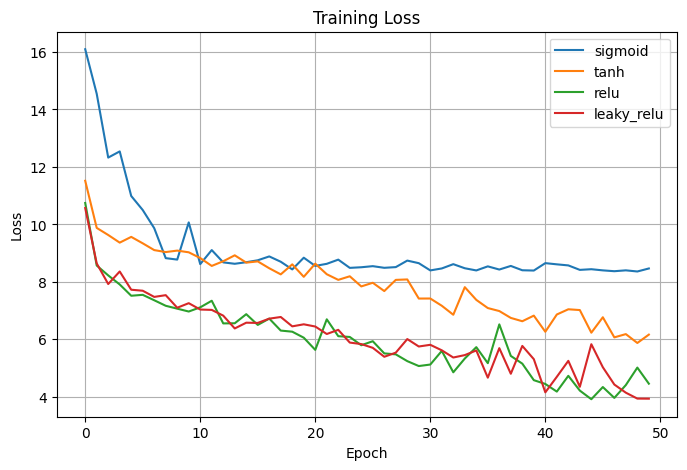

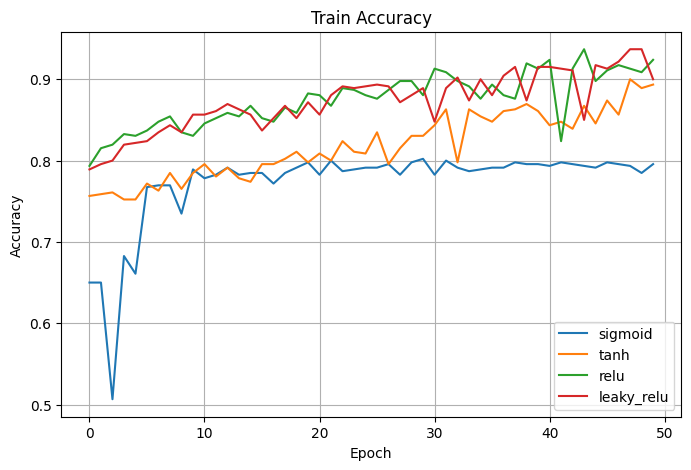

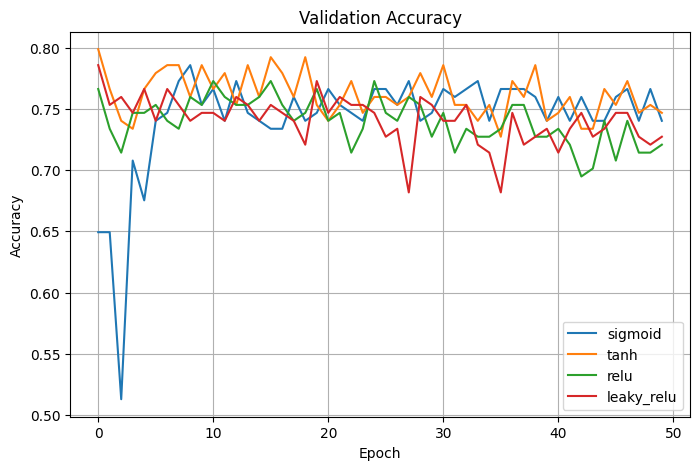

In [21]:
plt.figure(figsize=(8,5))
for a in activations:
    plt.plot(results[a]['history']['loss'], label=a)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for a in activations:
    plt.plot(results[a]['history']['train_acc'], label=a)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for a in activations:
    plt.plot(results[a]['history']['val_acc'], label=a)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

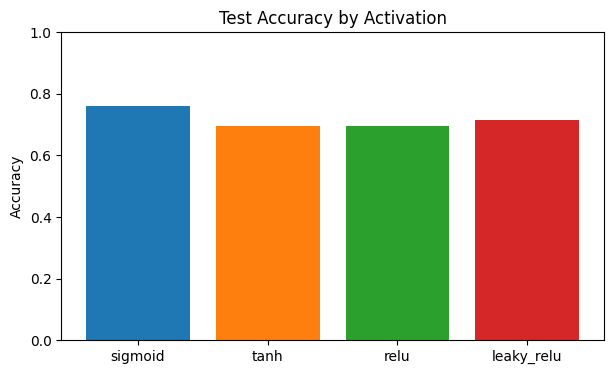

In [22]:
accs = [results[a]['metrics']['accuracy'] for a in activations]
plt.figure(figsize=(7,4))
plt.bar(activations, accs, color=['C0','C1','C2','C3'])
plt.ylim(0,1)
plt.title('Test Accuracy by Activation')
plt.ylabel('Accuracy')
plt.show()

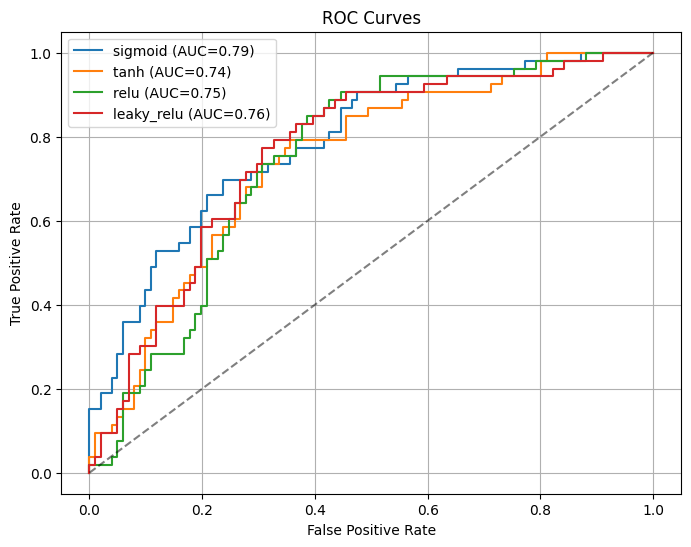

In [23]:
plt.figure(figsize=(8,6))
for a in activations:
    probs = results[a]['metrics']['probs']
    fpr, tpr, _ = roc_curve(y_test.flatten().astype(int), probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{a} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

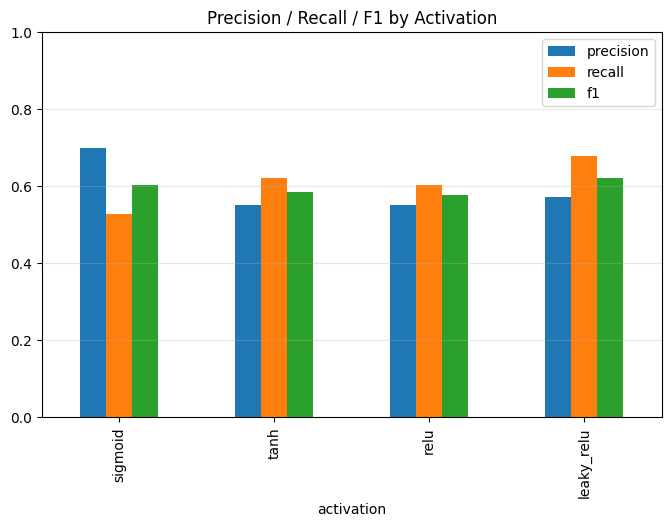

In [24]:
metrics_df = df_comp.set_index('activation')
metrics_df[['precision','recall','f1']].plot(kind='bar', figsize=(8,5))
plt.title('Precision / Recall / F1 by Activation')
plt.ylim(0,1)
plt.grid(axis='y', alpha=0.3)
plt.show()

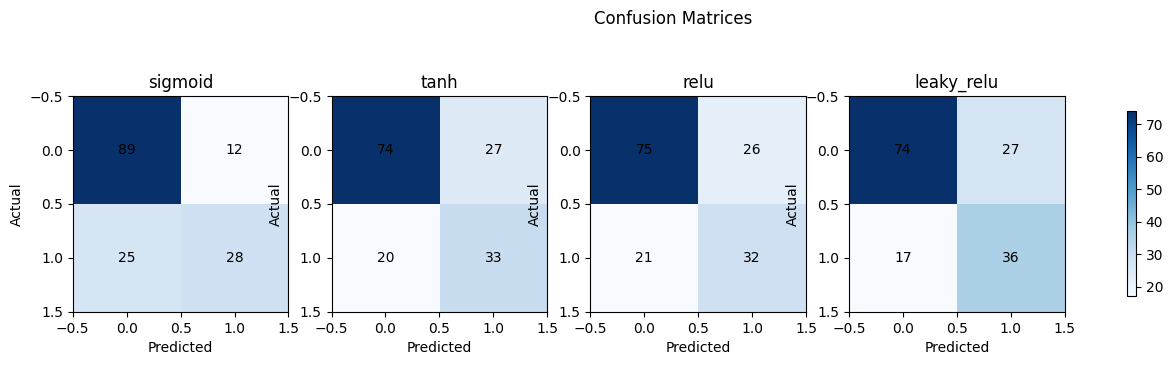

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i, a in enumerate(activations):
    cm = confusion_matrix(y_test.flatten().astype(int), results[a]['metrics']['labels'])
    ax = axes[i]
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(a)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    for (j,k), val in np.ndenumerate(cm):
        ax.text(k, j, val, ha='center', va='center')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.suptitle('Confusion Matrices')
plt.show()

## Analysis

**Comparison Table**: Shows accuracy, precision, recall, and F1 scores for each activation function on the test set.

**Plot 1-3**: Training loss, train accuracy, and validation accuracy curves show convergence behavior and training dynamics across activations.

**Plot 4**: Test accuracy bar chart provides a direct comparison of final test performance.

**Plot 5**: ROC curves with AUC scores demonstrate classification performance across different thresholds.

**Plot 6**: Precision, recall, and F1 metrics comparison reveals trade-offs between false positives and false negatives.

**Plot 7**: Confusion matrices show the distribution of true positives, true negatives, false positives, and false negatives for each activation.

**Key Findings**: ReLU and LeakyReLU typically converge faster and achieve higher accuracy compared to Sigmoid and Tanh due to reduced vanishing gradient problems. LeakyReLU often provides slightly better stability by preventing dying neurons.